<a href="https://colab.research.google.com/github/menon92/DL-Sneak-Peek/blob/master/image_data_pipeline_using_Sequence_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import random
import pathlib
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
# dataset link
DATASET_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

# download and untar the image dataset
data_dir = tf.keras.utils.get_file(
    origin=DATASET_URL,
    fname='flower_photos',
    untar=True
)
print('Dataset directory:', data_dir)

228818944/228813984 [==============================] - 3s 0us/step
Dataset directory: /root/.keras/datasets/flower_photos


In [3]:
# show what contarins the data directory
os.listdir(data_dir)

['dandelion', 'roses', 'sunflowers', 'tulips', 'LICENSE.txt', 'daisy']

In [4]:
# flower name to integer label maping
FLOWER_NAME_TO_INT_LABEL = {'tulips': 0, 'dandelion': 1, 'roses': 2, 'daisy': 3, 'sunflowers': 4}

# integer label to flowr name maping
INT_LABEL_TO_FLOWR_NAME = {0: 'tulips', 1: 'dandelion', 2: 'roses', 3: 'daisy', 4: 'sunflowers'}

In [5]:
# grab paths of all the image contrain in `floer_photos`
images_list = glob.glob(data_dir+"/*/*.jpg")

# print some images
for i in range(5):
    print(images_list[i])

print('-' * 30)
# print total images we found
print("Total image found: {}".format(len(images_list)))

/root/.keras/datasets/flower_photos/dandelion/5772194932_60b833091f.jpg
/root/.keras/datasets/flower_photos/dandelion/8757650550_113d7af3bd.jpg
/root/.keras/datasets/flower_photos/dandelion/8270191872_61e47ae3b8_m.jpg
/root/.keras/datasets/flower_photos/dandelion/5598845098_13e8e9460f.jpg
/root/.keras/datasets/flower_photos/dandelion/17346385582_7ba433dbbe.jpg
------------------------------
Total image found: 3670


In [6]:
class FlowerData(tf.keras.utils.Sequence):
    ''' Generate flower data '''
    def __init__(
        self, 
        images, 
        labels, 
        resized_shape, 
        color='rgb', 
        batch_size=32, 
        normalized=True,
        shuffle=True
    ):
        self.images = images
        self.labels = labels
        self.resized_shape = resized_shape
        self.color = color
        self.batch_size = batch_size
        self.normalized = normalized
        self.shuffle = shuffle

    def __len__(self):
        ''' Return number of steps per epochs '''
        return len(self.images) // self.batch_size
    
    def __getitem__(self, idx):
        ''' Given batch number (index) as argument and return that batch '''
        # take chunk of ith batch data
        x_batch = self.images[idx*self.batch_size:(idx+1)*self.batch_size]
        y_batch = self.labels[idx*self.batch_size:(idx+1)*self.batch_size]

        x = [None] * self.batch_size
        y = [None] * self.batch_size
        # cretae i'th batch
        for i, (image_path, label) in enumerate(zip(x_batch, y_batch)):
            # read and preprocess image
            image = self.__preprocess_image_file(image_path)
            # store image numpy and int label
            x[i] = image
            y[i] = label
        # convert list to numpy
        x = np.array(x)
        x = x.astype('float32')
        y = np.array(y)

        # scale image to 0 to 1
        if self.normalized:
            x = x / 255.

        return {
            'inputs': x,
            'targets': y
        }

    def __preprocess_image_file(self, file_path):
        ''' Preprocess image file '''
        # read image
        img_pil = Image.open(file_path)
        # convert image to gray scale
        if self.color == 'gray':
            img_pil = img_pil.convert('L')
        # resize image
        img_pil = img_pil.resize(self.resized_shape)
        # convert PIL image to numpy
        img_np  = np.array(img_pil)

        return img_np

    def on_epoch_end(self):
        ''' Shuffle data after each epochs '''
        if self.shuffle:
            __data = list(zip(self.images, self.labels))
            random.shuffle(__data)
            self.images, self.labels = zip(*__data)

In [7]:
def get_label_from_path(path):
    ''' Extract class int label from image path '''
    label = path.split('/')[-2]
    int_label = FLOWER_NAME_TO_INT_LABEL[label]
    return int_label


In [9]:
# grab image paths
images = glob.glob(data_dir + "/*/*.jpg")

# labels of the images
labels = [get_label_from_path(path) for path in images]

print("Total images: {}".format(len(images)))
print("total lables: {}".format(len(labels)))

Total images: 3670
total lables: 3670


In [10]:
# spilt data int train and test
x_train, x_test, y_train, y_test = train_test_split(
    images,
    labels,
    test_size=0.1,
    random_state=7
)
print("x_train: {}".format(len(x_train)))
print("x_test : {}".format(len(x_test)))
print("y_train: {}".format(len(y_train)))
print('y_test : {}'.format(len(y_test)))

x_train: 3303
x_test : 367
y_train: 3303
y_test : 367


In [11]:
# train data generator
train_data = FlowerData(
    images=x_train,
    labels=y_train,
    resized_shape=(224, 224),
    batch_size=64
)

# validation data generator
valid_data = FlowerData(
    images=x_test,
    labels=y_test,
    resized_shape=(224, 224),
    batch_size=32
)

In [12]:
# take 0'th batch images
sample_data = valid_data[1]
print('Sample batch image shape:', sample_data['inputs'].shape)
print('Sampel batch label shape:', sample_data['targets'].shape)

Sample batch image shape: (32, 224, 224, 3)
Sampel batch label shape: (32,)


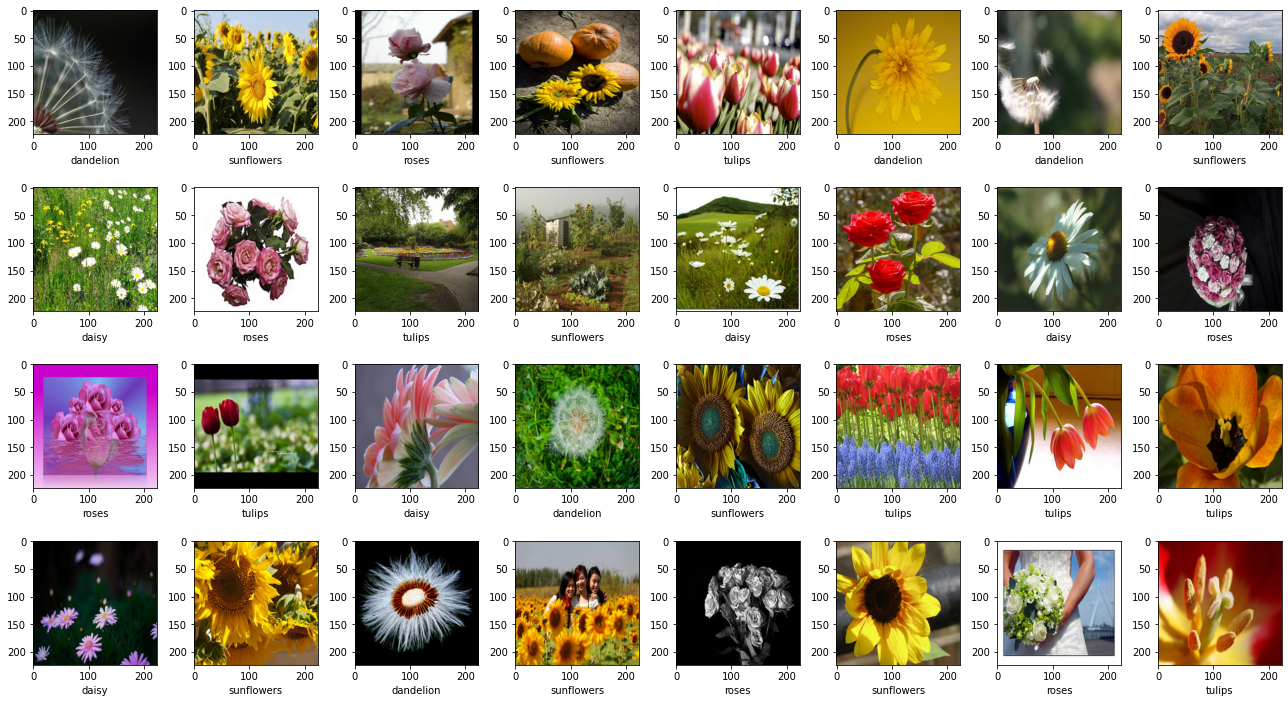

In [13]:
row, col = 4, 8
n_data_to_plot = row*col

#  plot image data
plt.figure(figsize=(18, 10))
for i in range(32):
    # extact image and it's lable from batch data
    image = sample_data['inputs'][i]
    int_label = sample_data['targets'][i]

    # plot image
    plt.subplot(row, col, i+1)
    plt.imshow(image)
    plt.xlabel(INT_LABEL_TO_FLOWR_NAME[int_label])
plt.tight_layout()
plt.show()